In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph
from IPython.display import Image, display

# MY EXAMPLES : 

## Made a graph using private state, which does some basic arithmetic operations

In [2]:
# Cell 1: Imports and State Definitions
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# Public/overall state (what user sees at entry/output)
class OverallState(TypedDict):
    total: int

# Private state (used only between nodes)
class PrivateState(TypedDict):
    temp: int

In [3]:
# Cell 2: Node Definitions
# First node reads from overall state, passes work via private state
def node_1(state: OverallState) -> PrivateState:
    # increment total and keep it private as 'temp'
    return {"temp": state["total"] + 1}

# Second node accepts private state and emits new overall state
def node_2(state: PrivateState) -> OverallState:
    return {"total": state["temp"] * 2}

In [4]:
# Cell 3: Build and run the graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

graph = builder.compile()

# Run the graph with starting total=5
result = graph.invoke({"total": 5})
print("Final output:", result)


Final output: {'total': 12}


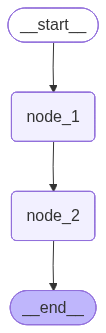

In [5]:
# Cell 4: Visualize (Mermaid)
mermaid_code = graph.get_graph().draw_mermaid()
#print(mermaid_code)
display(Image(graph.get_graph().draw_mermaid_png()))

## Made another graph using PrivateState which takes a string input and determines whether its a short sentence or long sentence 

In [6]:
 # Cell 1: Imports and State Definitions
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# Overall state (input/output)
class OverallState(TypedDict):
    sentence: str
    label: str

# Private state (intermediate only)
class PrivateState(TypedDict):
    word_count: int

In [7]:
# Cell 2: Node Definitions

# Node 1: Counts words, stores count privately
def count_words(state: OverallState) -> PrivateState:
    n = len(state['sentence'].split())
    return {'word_count': n}

# Node 2: Labels as "short" or "long" based on private word count
def label_sentence(state: PrivateState) -> OverallState:
    label = "short" if state['word_count'] <= 5 else "long"
    # restoring original sentence plus new label
    return {'sentence': '', 'label': label}

In [8]:
# Cell 3: Build and run the graph
builder = StateGraph(OverallState)
builder.add_node("count_words", count_words)
builder.add_node("label_sentence", label_sentence)

builder.add_edge(START, "count_words")
builder.add_edge("count_words", "label_sentence")
builder.add_edge("label_sentence", END)

graph = builder.compile()

### Tried with a short sentence example

In [9]:
# Example: Run on a short sentence
result = graph.invoke({'sentence': 'Hello world!', 'label': ''})
print("Short sentence output:", result)



Short sentence output: {'sentence': '', 'label': 'short'}


### and a long sentence example

In [10]:
# Example: Run on a long sentence
result2 = graph.invoke({'sentence': 'Open source machine learning is transforming research rapidly.', 'label': ''})
print("Long sentence output:", result2)

Long sentence output: {'sentence': '', 'label': 'long'}


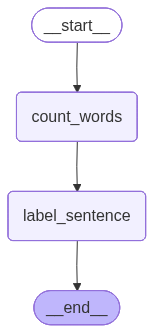

In [11]:
# Cell : Visualize (Mermaid)
mermaid_code = graph.get_graph().draw_mermaid()
#print(mermaid_code)
display(Image(graph.get_graph().draw_mermaid_png()))

## Created a graph using an input/output schema, it takes in two arithmetic valyues as input and gives the output after performing some arithmetic operations on it : 

In [12]:
# Cell 1: Import and schema definitions
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# Input schema
class InputSchema(TypedDict):
    num1: float
    num2: float
    op: str  # 'add', 'sub', 'mul', 'div'

# Output schema
class OutputSchema(TypedDict):
    result: float
    operation: str



In [13]:
# Cell 2: Node definitions
def calc_node(state: InputSchema) -> OutputSchema:
    if state["op"] == "add":
        res = state["num1"] + state["num2"]
        op_str = "addition"
    elif state["op"] == "sub":
        res = state["num1"] - state["num2"]
        op_str = "subtraction"
    elif state["op"] == "mul":
        res = state["num1"] * state["num2"]
        op_str = "multiplication"
    elif state["op"] == "div":
        res = state["num1"] / state["num2"] if state["num2"] != 0 else float("nan")
        op_str = "division"
    else:
        res = float('nan')
        op_str = "unknown"
    return {"result": res, "operation": op_str}



In [14]:
# Cell 3: Build the graph 
builder = StateGraph(
    OutputSchema,
    input_schema=InputSchema,
    output_schema=OutputSchema
)
builder.add_node("calc", calc_node)
builder.add_edge(START, "calc")
builder.add_edge("calc", END)
graph = builder.compile()

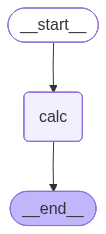

In [15]:
# Cell 4: Visualize (Mermaid)
mermaid_code = graph.get_graph().draw_mermaid()
#print(mermaid_code)
display(Image(graph.get_graph().draw_mermaid_png()))

### Tried it with different examples : 

#### we can see that only the output schema is visible to us as the result

In [16]:
# Example call 1
print("Addition test:", graph.invoke({"num1": 5, "num2": 3, "op": "add"}))


Addition test: {'result': 8, 'operation': 'addition'}


In [17]:
# Example call 2
print("Multiplication test:", graph.invoke({"num1": 7, "num2": 2, "op": "mul"}))

Multiplication test: {'result': 14, 'operation': 'multiplication'}


In [18]:
# Example call 3
print("Division by zero test:", graph.invoke({"num1": 10, "num2": 0, "op": "div"}))

Division by zero test: {'result': nan, 'operation': 'division'}
